In [1]:
import warnings
warnings.filterwarnings('ignore')

import itertools
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import sys

from itertools import combinations 
from scipy.integrate import cumtrapz
from scipy.stats import linregress
from scipy.stats import spearmanr
from scipy.stats import pearsonr

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

# import utils
sys.path.append("../../../utils")
from plotting_utils import *


%matplotlib inline
%config InlineBackend.figure_format = 'svg'
mpl.rcParams['figure.autolayout'] = False

In [2]:
sns.set(**PAPER_PRESET)
fontsize = PAPER_FONTSIZE

In [3]:
np.random.seed(2019)

In [4]:
QUANT_ALPHA = 0.05

## functions

In [5]:
def cis_trans_status(row):
    if row.cis_status_one == "significant cis effect":
        if row.trans_status_one == "significant trans effect":
            if "higher in human" in row.cis_status_det_one:
                if "higher in human" in row.trans_status_det_one:
                    return "cis/trans directional"
                else:
                    return "cis/trans compensatory"
            else:
                if "higher in human" in row.trans_status_det_one:
                    return "cis/trans compensatory"
                else:
                    return "cis/trans directional"
        else:
            return "cis effect only"
    else:
        if row.trans_status_one == "significant trans effect":
            return "trans effect only"
        else:
            return "no cis or trans effects"

## variables

In [6]:
data_f = "../../../data/02__mpra/03__results/all_processed_results.txt"

## 1. import data

In [7]:
data = pd.read_table(data_f, sep="\t")
data.head()

hg19_id chr_tss_hg19  start_tss_hg19 biotype_hg19  \
0     h.2         chr1       2985430.0    divergent   
1     h.3         chr1       8086552.0    divergent   
2     h.4         chr1      26498322.0    antisense   
3     h.5         chr1      65533428.0   intergenic   
4     h.6         chr1      65533462.0   intergenic   

                cage_id_hg19     name_peak_hg19 minimal_biotype_hg19  \
0    chr1:2985420..2985438,-  ENSG00000177133.6               lncRNA   
1    chr1:8086546..8086571,+  ENSG00000238290.1               lncRNA   
2  chr1:26498321..26498327,-  ENSG00000236782.1                other   
3  chr1:65533390..65533443,-  ENSG00000231485.1               lncRNA   
4  chr1:65533457..65533465,-  ENSG00000231485.1               lncRNA   

         stem_exp_hg19 mm9_id chr_tss_mm9            ...             \
0  0.07111110000000001    m.1        chr4            ...              
1  0.10444400000000001    m.2        chr4            ...              
2                 0.03    m.3        chr4            ...              
3             0.841111    m.4        chr4            ...              
4             0.116667    m.4        chr4            ...              

   trans_mouse_status           trans_human_status_det trans_mouse_status_det  \
0     no trans effect                  no trans effect        no trans effect   
1     no trans effect                  no trans effect        no trans effect   
2     no trans effect                  no trans effect        no trans effect   
3     no trans effect  trans effect\n(higher in mouse)        no trans effect   
4     no trans effect                  no trans effect        no trans effect   

           trans_status_one             trans_status_det_one logFC_trans_one  \
0           no trans effect                  no trans effect       -0.325920   
1           no trans effect                  no trans effect        0.533476   
2           no trans effect                  no trans effect        0.270223   
3  significant trans effect  trans effect\n(higher in mouse)        0.449668   
4           no trans effect                  no trans effect       -0.270646   

  logFC_int   fdr_int      cis_trans_int_status  cis_trans_int_status_det  
0 -0.050780  0.991115  no cis/trans int. effect  no cis/trans int. effect  
1 -0.405629  0.908445  no cis/trans int. effect  no cis/trans int. effect  
2 -0.210732  0.960813  no cis/trans int. effect  no cis/trans int. effect  
3 -0.740913  0.152051  no cis/trans int. effect  no cis/trans int. effect  
4 -0.528464  0.379849  no cis/trans int. effect  no cis/trans int. effect  

[5 rows x 57 columns]

In [8]:
data["cis_trans_status"] = data.apply(cis_trans_status, axis=1)

## 2. filter data

In [9]:
data = data[~pd.isnull(data["minimal_biotype_hg19"])]
len(data)

2952

In [10]:
data_filt = data[((data["HUES64_padj_hg19"] < QUANT_ALPHA) | (data["mESC_padj_mm9"] < QUANT_ALPHA))]
len(data_filt)

1655

In [11]:
data_filt_sp = data_filt.drop("orig_species", axis=1)
data_filt_sp.drop_duplicates(inplace=True)
len(data_filt_sp)

1644

In [12]:
data_filt_sp.cis_trans_status.value_counts()

no cis or trans effects    850
cis effect only            501
trans effect only          134
cis/trans directional       95
cis/trans compensatory      64
Name: cis_trans_status, dtype: int64

In [13]:
# fisher's exact to see if cis/trans effects are enriched
cis_trans = len(data_filt_sp[data_filt_sp["cis_trans_status"].isin(["cis/trans directional", "cis/trans compensatory"])])
cis_no_trans = len(data_filt_sp[data_filt_sp["cis_trans_status"] == "cis effect only"])
trans_no_cis = len(data_filt_sp[data_filt_sp["cis_trans_status"] == "trans effect only"])
n_no_cis_trans = len(data_filt_sp[data_filt_sp["cis_trans_status"] == "no cis or trans effects"])

# fisher's exact test
arr = np.zeros((2, 2))
arr[0, 0] = cis_trans
arr[0, 1] = cis_no_trans
arr[1, 0] = trans_no_cis
arr[1, 1] = n_no_cis_trans
print(arr)

odds, p = stats.fisher_exact(arr)
print(odds)
print(p)

[[ 159.  501.]
 [ 134.  850.]]
2.0131379033
8.59951711423e-08


In [14]:
stats.binom_test(95, 159)

0.017077471627514162

In [15]:
# data_filt_tile1 = data_filt[data_filt["tss_tile_num"] == "tile1"]
# len(data_filt_tile1)

In [16]:
# data_filt_tile1_sp = data_filt_sp[data_filt_sp["tss_tile_num"] == "tile1"]
# len(data_filt_tile1_sp)

In [17]:
# data_filt_tile2 = data_filt[data_filt["tss_tile_num"] == "tile2"]
# len(data_filt_tile2)

In [18]:
# data_filt_tile2_sp = data_filt_sp[data_filt_sp["tss_tile_num"] == "tile2"]
# len(data_filt_tile2_sp)

## count of cis/trans/both

In [19]:
len(data_filt_sp)

1644

In [20]:
len(data_filt_sp[(data_filt_sp["cis_status_one"] != "no cis effect") & (data_filt_sp["trans_status_one"] == "no trans effect")])

501

In [21]:
len(data_filt_sp[(data_filt_sp["cis_status_one"] == "no cis effect") & (data_filt_sp["trans_status_one"] != "no trans effect")])


134

In [22]:
len(data_filt_sp[(data_filt_sp["cis_status_one"] != "no cis effect") & (data_filt_sp["trans_status_one"] != "no trans effect")])

159

## 3. count of cis/trans interactions

In [23]:
int_order = ["no cis/trans int. effect", "significant cis/trans int. effect"]
int_pal = {"no cis/trans int. effect": "gray", "significant cis/trans int. effect": "black"}

In [24]:
# dfs = [data_filt_sp, data_filt_tile1_sp, data_filt_tile2_sp]
# titles = ["both tiles", "tile1 only", "tile2 only"]
# labels = ["both_tiles", "tile1_only", "tile2_only"]

In [25]:
# for df, title, label in zip(dfs, titles, labels):
    
#     fig, ax = plt.subplots(figsize=(0.75, 1.75), nrows=1, ncols=1)

#     sns.countplot(data=df, x="cis_trans_int_status", palette=int_pal, order=int_order, linewidth=2, 
#                   edgecolor=int_pal.values(), ax=ax)
#     ax.set_xticklabels(["no cis/trans interaction", "cis/trans interaction"], va="top", ha="right", rotation=50)
#     ax.set_xlabel("")
#     ax.set_title(title)
    
#     tot = 0
#     colors = ["white", "black"]
#     for i, l in enumerate(int_order):
#         n = len(df[df["cis_trans_int_status"] == l])
#         tot += n
#         ax.annotate(str(n), xy=(i, 40), xycoords="data", xytext=(0, 0), 
#                     textcoords="offset pixels", ha='center', va='bottom', 
#                     color=colors[i], size=fontsize)
#     print("percent cis/trans sig: %s" % (n/tot))

#     plt.show()
#     fig.savefig("count_cistrans_status.%s.pdf" % label, dpi="figure", bbox_inches="tight")
#     plt.close()

In [26]:
df = data_filt_sp

percent cis/trans sig: 0.03102189781021898


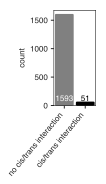

In [27]:
fig, ax = plt.subplots(figsize=(0.75, 1.75), nrows=1, ncols=1)

sns.countplot(data=df, x="cis_trans_int_status", palette=int_pal, order=int_order, linewidth=2, 
              edgecolor=int_pal.values(), ax=ax)
ax.set_xticklabels(["no cis/trans interaction", "cis/trans interaction"], va="top", ha="right", rotation=50)
ax.set_xlabel("")

tot = 0
colors = ["white", "black"]
for i, l in enumerate(int_order):
    n = len(df[df["cis_trans_int_status"] == l])
    tot += n
    ax.annotate(str(n), xy=(i, 50), xycoords="data", xytext=(0, 0), 
                textcoords="offset pixels", ha='center', va='bottom', 
                color=colors[i], size=fontsize)
print("percent cis/trans sig: %s" % (n/tot))

plt.show()
fig.savefig("count_cistrans_status.pdf", dpi="figure", bbox_inches="tight")
plt.close()

## 5. effect size differences across biotypes

In [28]:
min_switch_order = ["CAGE turnover - eRNA", "CAGE turnover - lncRNA", "CAGE turnover - mRNA", 
                    "eRNA", "lncRNA", "mRNA"]
min_switch_pal = {"CAGE turnover - eRNA": sns.color_palette("Set2")[2], 
                  "CAGE turnover - lncRNA": sns.color_palette("Set2")[2],
                  "CAGE turnover - mRNA": sns.color_palette("Set2")[2],
                  "eRNA": sns.color_palette("Set2")[7], 
                  "lncRNA": sns.color_palette("Set2")[7], 
                  "mRNA": sns.color_palette("Set2")[7]}

In [29]:
# for df, title, label in zip(dfs, titles, labels):
#     df["abs_logFC_int"] = np.abs(df["logFC_int"])

#     fig = plt.figure(figsize=(2.5, 1.5))
#     ax = sns.boxplot(data=df, x="biotype_switch_minimal", y="abs_logFC_int", 
#                      flierprops = dict(marker='o', markersize=5), 
#                      order=min_switch_order, palette=min_switch_pal)
#     mimic_r_boxplot(ax)

#     ax.set_xticklabels(["eRNA", "lncRNA", "mRNA", "eRNA", "lncRNA", "mRNA"], rotation=50, ha='right', va='top')
#     ax.set_xlabel("")
#     ax.set_ylabel("cis/trans interaction\neffect size")
#     ax.set_title(title)

#     for i, l in enumerate(min_switch_order):
#         sub = df[df["biotype_switch_minimal"] == l]
#         n = len(sub)
#         print("%s median eff size: %s" % (l, sub["abs_logFC_int"].median()))
#         color = min_switch_pal[l]
#         ax.annotate(str(n), xy=(i, -0.3), xycoords="data", xytext=(0, 0), 
#                     textcoords="offset pixels", ha='center', va='bottom', 
#                     color=color, size=fontsize)
        
#     ### pvals ###
#     vals1 = np.asarray(df[df["biotype_switch_minimal"] == "CAGE turnover - eRNA"]["abs_logFC_int"])
#     vals2 = np.asarray(df[df["biotype_switch_minimal"] == "CAGE turnover - lncRNA"]["abs_logFC_int"])
#     vals3 = np.asarray(df[df["biotype_switch_minimal"] == "CAGE turnover - mRNA"]["abs_logFC_int"])
#     vals4 = np.asarray(df[df["biotype_switch_minimal"] == "eRNA"]["abs_logFC_int"])
#     vals5 = np.asarray(df[df["biotype_switch_minimal"] == "lncRNA"]["abs_logFC_int"])
#     vals6 = np.asarray(df[df["biotype_switch_minimal"] == "mRNA"]["abs_logFC_int"])
    
#     vals1 = vals1[~np.isnan(vals1)]
#     vals2 = vals2[~np.isnan(vals2)]
#     vals3 = vals3[~np.isnan(vals3)]
#     vals4 = vals4[~np.isnan(vals4)]
#     vals5 = vals5[~np.isnan(vals5)]
#     vals6 = vals6[~np.isnan(vals6)]
    
#     _, pval12 = stats.mannwhitneyu(vals1, vals2, alternative="two-sided", use_continuity=False)
#     _, pval13 = stats.mannwhitneyu(vals1, vals3, alternative="two-sided", use_continuity=False)
#     _, pval23 = stats.mannwhitneyu(vals2, vals3, alternative="two-sided", use_continuity=False)
#     _, pval45 = stats.mannwhitneyu(vals4, vals5, alternative="two-sided", use_continuity=False)
#     _, pval46 = stats.mannwhitneyu(vals4, vals6, alternative="two-sided", use_continuity=False)
#     _, pval56 = stats.mannwhitneyu(vals5, vals6, alternative="two-sided", use_continuity=False)
    
#     print(pval12)
#     print(pval13)
#     print(pval23)
#     print(pval45)
#     print(pval46)
#     print(pval56)
    
#     annotate_pval(ax, 0.2, 0.8, 1.25, 0, 1.25, pval12, fontsize-1)
#     annotate_pval(ax, 1.2, 1.8, 1.25, 0, 1.25, pval13, fontsize-1)
#     annotate_pval(ax, 0, 2, 1.75, 0, 1.75, pval23, fontsize-1)
#     annotate_pval(ax, 3.2, 3.8, 1.25, 0, 1.25, pval45, fontsize-1)
#     annotate_pval(ax, 4.2, 4.8, 1.25, 0, 1.25, pval56, fontsize-1)
#     annotate_pval(ax, 3, 5, 1.75, 0, 1.75, pval46, fontsize-1)

#     ax.set_ylim((-0.4, 2))
#     ax.axvline(x=2.5, linestyle="dashed", color="black")

#     plt.show()
#     fig.savefig("cistrans_minimal_biotype_switch_effectsize_boxplot.%s.pdf" % label, dpi="figure", bbox_inches="tight")
#     plt.close()

CAGE turnover - eRNA median eff size: 0.318964128462853
CAGE turnover - lncRNA median eff size: 0.2993994205322035
CAGE turnover - mRNA median eff size: 0.387485373505631
eRNA median eff size: 0.3224732381008125
lncRNA median eff size: 0.233697348783086
mRNA median eff size: 0.237849700038464
0.349005269895
0.611415567231
0.838091759197
0.000674993072772
0.00242304267909
0.548755029998


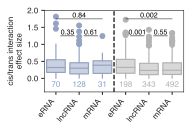

In [30]:
df["abs_logFC_int"] = np.abs(df["logFC_int"])

fig = plt.figure(figsize=(2.5, 1.5))
ax = sns.boxplot(data=df, x="biotype_switch_minimal", y="abs_logFC_int", 
                 flierprops = dict(marker='o', markersize=5), 
                 order=min_switch_order, palette=min_switch_pal)
mimic_r_boxplot(ax)

ax.set_xticklabels(["eRNA", "lncRNA", "mRNA", "eRNA", "lncRNA", "mRNA"], rotation=50, ha='right', va='top')
ax.set_xlabel("")
ax.set_ylabel("cis/trans interaction\neffect size")

for i, l in enumerate(min_switch_order):
    sub = df[df["biotype_switch_minimal"] == l]
    n = len(sub)
    print("%s median eff size: %s" % (l, sub["abs_logFC_int"].median()))
    color = min_switch_pal[l]
    ax.annotate(str(n), xy=(i, -0.3), xycoords="data", xytext=(0, 0), 
                textcoords="offset pixels", ha='center', va='bottom', 
                color=color, size=fontsize)

### pvals ###
vals1 = np.asarray(df[df["biotype_switch_minimal"] == "CAGE turnover - eRNA"]["abs_logFC_int"])
vals2 = np.asarray(df[df["biotype_switch_minimal"] == "CAGE turnover - lncRNA"]["abs_logFC_int"])
vals3 = np.asarray(df[df["biotype_switch_minimal"] == "CAGE turnover - mRNA"]["abs_logFC_int"])
vals4 = np.asarray(df[df["biotype_switch_minimal"] == "eRNA"]["abs_logFC_int"])
vals5 = np.asarray(df[df["biotype_switch_minimal"] == "lncRNA"]["abs_logFC_int"])
vals6 = np.asarray(df[df["biotype_switch_minimal"] == "mRNA"]["abs_logFC_int"])

vals1 = vals1[~np.isnan(vals1)]
vals2 = vals2[~np.isnan(vals2)]
vals3 = vals3[~np.isnan(vals3)]
vals4 = vals4[~np.isnan(vals4)]
vals5 = vals5[~np.isnan(vals5)]
vals6 = vals6[~np.isnan(vals6)]

_, pval12 = stats.mannwhitneyu(vals1, vals2, alternative="two-sided", use_continuity=False)
_, pval13 = stats.mannwhitneyu(vals1, vals3, alternative="two-sided", use_continuity=False)
_, pval23 = stats.mannwhitneyu(vals2, vals3, alternative="two-sided", use_continuity=False)
_, pval45 = stats.mannwhitneyu(vals4, vals5, alternative="two-sided", use_continuity=False)
_, pval46 = stats.mannwhitneyu(vals4, vals6, alternative="two-sided", use_continuity=False)
_, pval56 = stats.mannwhitneyu(vals5, vals6, alternative="two-sided", use_continuity=False)

print(pval12)
print(pval13)
print(pval23)
print(pval45)
print(pval46)
print(pval56)

annotate_pval(ax, 0.2, 0.8, 1.25, 0, 1.25, pval12, fontsize-1)
annotate_pval(ax, 1.2, 1.8, 1.25, 0, 1.25, pval13, fontsize-1)
annotate_pval(ax, 0, 2, 1.75, 0, 1.75, pval23, fontsize-1)
annotate_pval(ax, 3.2, 3.8, 1.25, 0, 1.25, pval45, fontsize-1)
annotate_pval(ax, 4.2, 4.8, 1.25, 0, 1.25, pval56, fontsize-1)
annotate_pval(ax, 3, 5, 1.75, 0, 1.75, pval46, fontsize-1)

ax.set_ylim((-0.4, 2))
ax.axvline(x=2.5, linestyle="dashed", color="black")

plt.show()
fig.savefig("cistrans_minimal_biotype_switch_effectsize_boxplot.pdf", dpi="figure", bbox_inches="tight")
plt.close()

In [31]:
def cage_status(row):
    if "CAGE turnover" in row.biotype_switch_minimal:
        return "turnover"
    else:
        return "conserved"

In [32]:
def one_biotype(row):
    if row.minimal_biotype_hg19 == "no CAGE activity":
        return row.minimal_biotype_mm9
    elif row.biotype_switch_minimal == "biotype switch":
        return "biotype switch"
    else:
        return row.minimal_biotype_hg19

In [33]:
pal = {"conserved": sns.color_palette("Set2")[7], "turnover": sns.color_palette("Set2")[2]}

In [34]:
# for df, title, pltname in zip(dfs, titles, labels):
#     df["abs_logFC_int"] = np.abs(df["logFC_int"])
#     df["cage_status"] = df.apply(cage_status, axis=1)
#     df["one_biotype"] = df.apply(one_biotype, axis=1)
    
#     fig = plt.figure(figsize=(2.75, 1.5))

#     ax = sns.boxplot(data=df, x="one_biotype", y="abs_logFC_int", hue="cage_status",
#                      flierprops = dict(marker='o', markersize=5),
#                      order=["eRNA", "lncRNA", "mRNA"], hue_order=["turnover", "conserved"], palette=pal)
#     mimic_r_boxplot(ax)

#     ax.set_xticklabels(["eRNA", "lncRNA", "mRNA"], rotation=50, ha='right', va='top')
#     ax.set_xlabel("")
#     ax.set_ylabel("trans effect size")
#     plt.legend(loc=2, bbox_to_anchor=(1.05, 1))

#     ys = [0.75, 0.75, 0.75]
#     for i, label in enumerate(["eRNA", "lncRNA", "mRNA"]):
#         sub = df[df["one_biotype"] == label]
#         sub1 = sub[sub["cage_status"] == "turnover"]
#         sub2 = sub[sub["cage_status"] == "conserved"]

#         vals1 = np.asarray(sub1["abs_logFC_int"])
#         vals2 = np.asarray(sub2["abs_logFC_int"])

#         vals1 = vals1[~np.isnan(vals1)]
#         vals2 = vals2[~np.isnan(vals2)]

#         u, pval = stats.mannwhitneyu(vals1, vals2, alternative="two-sided", use_continuity=False)
#         print(pval)

#         if pval >= 0.05:
#             annotate_pval(ax, i-0.1, i+0.1, ys[i], 0, ys[i], pval, fontsize-1)
#         else:
#             annotate_pval(ax, i-0.1, i+0.1, ys[i], 0, ys[i], pval, fontsize-1)

#         n1 = len(vals1)
#         n2 = len(vals2)

#         ax.annotate(str(n1), xy=(i-0.2, -0.3), xycoords="data", xytext=(0, 0), 
#                     textcoords="offset pixels", ha='center', va='bottom', 
#                     color=pal["turnover"], size=fontsize)
#         ax.annotate(str(n2), xy=(i+0.2, -0.3), xycoords="data", xytext=(0, 0), 
#                     textcoords="offset pixels", ha='center', va='bottom', 
#                     color=pal["conserved"], size=fontsize)

#     ax.set_ylim((-0.4, 2))
#     ax.set_title(title)
#     fig.savefig("cistrans_effect_biotype_sep_cage.%s.pdf" % pltname, dpi="figure", bbox_inches="tight")

0.949932528271
0.114857665206
0.41445107643


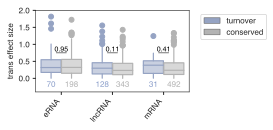

In [35]:
df["abs_logFC_int"] = np.abs(df["logFC_int"])
df["cage_status"] = df.apply(cage_status, axis=1)
df["one_biotype"] = df.apply(one_biotype, axis=1)

fig = plt.figure(figsize=(2.75, 1.5))

ax = sns.boxplot(data=df, x="one_biotype", y="abs_logFC_int", hue="cage_status",
                 flierprops = dict(marker='o', markersize=5),
                 order=["eRNA", "lncRNA", "mRNA"], hue_order=["turnover", "conserved"], palette=pal)
mimic_r_boxplot(ax)

ax.set_xticklabels(["eRNA", "lncRNA", "mRNA"], rotation=50, ha='right', va='top')
ax.set_xlabel("")
ax.set_ylabel("trans effect size")
plt.legend(loc=2, bbox_to_anchor=(1.05, 1))

ys = [0.75, 0.75, 0.75]
for i, label in enumerate(["eRNA", "lncRNA", "mRNA"]):
    sub = df[df["one_biotype"] == label]
    sub1 = sub[sub["cage_status"] == "turnover"]
    sub2 = sub[sub["cage_status"] == "conserved"]

    vals1 = np.asarray(sub1["abs_logFC_int"])
    vals2 = np.asarray(sub2["abs_logFC_int"])

    vals1 = vals1[~np.isnan(vals1)]
    vals2 = vals2[~np.isnan(vals2)]

    u, pval = stats.mannwhitneyu(vals1, vals2, alternative="two-sided", use_continuity=False)
    print(pval)

    if pval >= 0.05:
        annotate_pval(ax, i-0.1, i+0.1, ys[i], 0, ys[i], pval, fontsize-1)
    else:
        annotate_pval(ax, i-0.1, i+0.1, ys[i], 0, ys[i], pval, fontsize-1)

    n1 = len(vals1)
    n2 = len(vals2)

    ax.annotate(str(n1), xy=(i-0.2, -0.3), xycoords="data", xytext=(0, 0), 
                textcoords="offset pixels", ha='center', va='bottom', 
                color=pal["turnover"], size=fontsize)
    ax.annotate(str(n2), xy=(i+0.2, -0.3), xycoords="data", xytext=(0, 0), 
                textcoords="offset pixels", ha='center', va='bottom', 
                color=pal["conserved"], size=fontsize)

ax.set_ylim((-0.4, 2))
fig.savefig("cistrans_effect_biotype_sep_cage.pdf", dpi="figure", bbox_inches="tight")

## 6. percent sig across biotypes

In [36]:
# for df, title, label in zip(dfs, titles, labels):

#     tots = df.groupby("biotype_switch_minimal")["hg19_id"].agg("count").reset_index()
#     sig = df[df["cis_trans_int_status"] != "no cis/trans int. effect"].groupby("biotype_switch_minimal")["hg19_id"].agg("count").reset_index()
#     clean_sig = tots.merge(sig, on="biotype_switch_minimal", how="left").fillna(0)
#     clean_sig["percent_sig"] = (clean_sig["hg19_id_y"]/clean_sig["hg19_id_x"])*100
    
#     fig = plt.figure(figsize=(2.5, 1.5))
#     ax = sns.barplot(data=clean_sig, x="biotype_switch_minimal", y="percent_sig", 
#                      order=min_switch_order, color=sns.color_palette("Set2")[2])

#     ax.set_xticklabels(["eRNA", "lncRNA", "mRNA", "eRNA", "lncRNA", "mRNA"], rotation=50, ha='right', va='top')
#     ax.set_xlabel("")
#     ax.set_ylabel("% of seq. pairs with\ncis/trans interactions")
#     ax.set_title(title)
#     ax.axvline(x=2.5, linestyle="dashed", color="black")
    
#     for i, l in enumerate(min_switch_order):
#         sub = clean_sig[clean_sig["biotype_switch_minimal"] == l]
#         print("%s perc sig: %s" % (l, sub["percent_sig"].iloc[0]))
#         n = sub["hg19_id_x"].iloc[0]
#         ax.annotate(str(n), xy=(i, 0.5), xycoords="data", xytext=(0, 0), 
#                     textcoords="offset pixels", ha='center', va='bottom', 
#                     color="white", size=fontsize)
    
#     plt.show()
#     fig.savefig("perc_sig_cistrans_minimal_biotype_switch.%s.pdf" % label, dpi="figure", bbox_inches="tight")
#     plt.close()

CAGE turnover - eRNA perc sig: 4.28571428571
CAGE turnover - lncRNA perc sig: 3.125
CAGE turnover - mRNA perc sig: 0.0
eRNA perc sig: 6.06060606061
lncRNA perc sig: 2.04081632653
mRNA perc sig: 2.64227642276


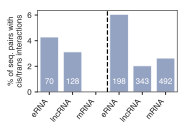

In [37]:
tots = df.groupby("biotype_switch_minimal")["hg19_id"].agg("count").reset_index()
sig = df[df["cis_trans_int_status"] != "no cis/trans int. effect"].groupby("biotype_switch_minimal")["hg19_id"].agg("count").reset_index()
clean_sig = tots.merge(sig, on="biotype_switch_minimal", how="left").fillna(0)
clean_sig["percent_sig"] = (clean_sig["hg19_id_y"]/clean_sig["hg19_id_x"])*100

fig = plt.figure(figsize=(2.5, 1.5))
ax = sns.barplot(data=clean_sig, x="biotype_switch_minimal", y="percent_sig", 
                 order=min_switch_order, color=sns.color_palette("Set2")[2])

ax.set_xticklabels(["eRNA", "lncRNA", "mRNA", "eRNA", "lncRNA", "mRNA"], rotation=50, ha='right', va='top')
ax.set_xlabel("")
ax.set_ylabel("% of seq. pairs with\ncis/trans interactions")
ax.axvline(x=2.5, linestyle="dashed", color="black")

for i, l in enumerate(min_switch_order):
    sub = clean_sig[clean_sig["biotype_switch_minimal"] == l]
    print("%s perc sig: %s" % (l, sub["percent_sig"].iloc[0]))
    n = sub["hg19_id_x"].iloc[0]
    ax.annotate(str(n), xy=(i, 0.5), xycoords="data", xytext=(0, 0), 
                textcoords="offset pixels", ha='center', va='bottom', 
                color="white", size=fontsize)

plt.show()
fig.savefig("perc_sig_cistrans_minimal_biotype_switch.pdf", dpi="figure", bbox_inches="tight")
plt.close()

## 7. look generally at significant interactions

In [38]:
# for df, title, label in zip(dfs, titles, labels):
    
#     # plot effect size agreement b/w the two cells
#     fig, ax = plt.subplots(figsize=(1.75, 1.75), nrows=1, ncols=1)

#     sig_int = df[df["cis_trans_int_status"] != "no cis/trans int. effect"]
#     not_sig_int = df[df["cis_trans_int_status"] == "no cis/trans int. effect"]

#     ax.scatter(not_sig_int["logFC_cis_HUES64"], not_sig_int["logFC_cis_mESC"], s=10, alpha=0.75, 
#                color="gray", linewidths=0.5, edgecolors="white")
#     ax.scatter(sig_int["logFC_cis_HUES64"], sig_int["logFC_cis_mESC"], s=10, alpha=1, 
#                color=sns.color_palette("Set2")[3], linewidths=0.5, edgecolors="white")

#     plt.xlabel("cis effect size in hESCs")
#     plt.ylabel("cis effect size in mESCs")

#     ax.axhline(y=0, color="black", linestyle="dashed")
#     ax.axvline(x=0, color="black", linestyle="dashed")
#     ax.set_xlim((-6, 6))
#     ax.set_ylim((-6, 6))

#     # annotate corr
#     no_nan = df[(~pd.isnull(df["logFC_cis_HUES64"])) & (~pd.isnull(df["logFC_cis_mESC"]))]
#     r, p = spearmanr(no_nan["logFC_cis_HUES64"], no_nan["logFC_cis_mESC"])
#     ax.text(0.05, 0.97, "r = {:.2f}".format(r), ha="left", va="top", fontsize=fontsize,
#             transform=ax.transAxes)
#     ax.text(0.05, 0.90, "n = %s" % (len(no_nan)), ha="left", va="top", fontsize=fontsize,
#             transform=ax.transAxes)
#     plt.show()
#     fig.savefig("cis_effect_bw_cells_scatter.sig_status_color.%s.pdf" % label, dpi="figure", bbox_inches="tight")
#     plt.close()

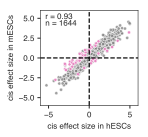

In [39]:
# plot effect size agreement b/w the two cells
fig, ax = plt.subplots(figsize=(1.75, 1.75), nrows=1, ncols=1)

sig_int = df[df["cis_trans_int_status"] != "no cis/trans int. effect"]
not_sig_int = df[df["cis_trans_int_status"] == "no cis/trans int. effect"]

ax.scatter(not_sig_int["logFC_cis_HUES64"], not_sig_int["logFC_cis_mESC"], s=10, alpha=0.75, 
           color="gray", linewidths=0.5, edgecolors="white")
ax.scatter(sig_int["logFC_cis_HUES64"], sig_int["logFC_cis_mESC"], s=10, alpha=1, 
           color=sns.color_palette("Set2")[3], linewidths=0.5, edgecolors="white")

plt.xlabel("cis effect size in hESCs")
plt.ylabel("cis effect size in mESCs")

ax.axhline(y=0, color="black", linestyle="dashed")
ax.axvline(x=0, color="black", linestyle="dashed")
ax.set_xlim((-6, 6))
ax.set_ylim((-6, 6))

# annotate corr
no_nan = df[(~pd.isnull(df["logFC_cis_HUES64"])) & (~pd.isnull(df["logFC_cis_mESC"]))]
r, p = spearmanr(no_nan["logFC_cis_HUES64"], no_nan["logFC_cis_mESC"])
ax.text(0.05, 0.97, "r = {:.2f}".format(r), ha="left", va="top", fontsize=fontsize,
        transform=ax.transAxes)
ax.text(0.05, 0.90, "n = %s" % (len(no_nan)), ha="left", va="top", fontsize=fontsize,
        transform=ax.transAxes)
plt.show()
fig.savefig("cis_effect_bw_cells_scatter.sig_status_color.pdf", dpi="figure", bbox_inches="tight")
plt.close()

## 8. look at highest cis/trans interactions

In [40]:
sig_int = df[df["cis_trans_int_status"] != "no cis/trans int. effect"]
len(sig_int)

51

In [41]:
# sig_int_filt = sig_int[((sig_int["logFC_cis_HUES64"] < 0) & (sig_int["logFC_cis_mESC"] > 0)) |
#                        ((sig_int["logFC_cis_HUES64"] > 0) & (sig_int["logFC_cis_mESC"] < 0))]
sig_int_filt = sig_int
len(sig_int_filt)

51

In [42]:
sub = sig_int_filt[["hg19_id", "mm9_id", "biotype_hg19", "biotype_mm9", "biotype_switch_minimal", "logFC_int", "logFC_cis_HUES64", "logFC_cis_mESC",
                    "HUES64_hg19", "mESC_hg19", "HUES64_mm9", "mESC_mm9", "cis_trans_status"]]
sub

hg19_id  mm9_id      biotype_hg19       biotype_mm9  \
128    h.229   m.147        intergenic        intergenic   
178    h.321   m.207        intergenic    protein_coding   
247    h.411   m.275         antisense          enhancer   
248    h.411   m.332         antisense          enhancer   
366    h.554   m.440    protein_coding    protein_coding   
423    h.667   m.553    protein_coding    protein_coding   
440    h.705   m.591    protein_coding    protein_coding   
590    h.980   m.863    protein_coding    protein_coding   
600    h.996   m.879    protein_coding    protein_coding   
664   h.1110   m.992    protein_coding    protein_coding   
701   h.1155  m.1027          enhancer          enhancer   
762   h.1217  m.1089          enhancer          enhancer   
799   h.1445  m.1127          enhancer          enhancer   
848   h.1305  m.1177          enhancer          enhancer   
891   h.1372  m.1231          enhancer          enhancer   
893   h.1374  m.1056          enhancer          enhancer   
905   h.1389  m.1247          enhancer          enhancer   
959   h.1485  m.1310          enhancer          enhancer   
968   h.1505  m.1323          enhancer          enhancer   
975   h.1517  m.1331          enhancer          enhancer   
989   h.1534  m.1346         antisense  no cage activity   
994   h.1543  m.1355         antisense  no cage activity   
1010  h.1564  m.1376         antisense  no cage activity   
1106  h.1734  m.1546         divergent  no cage activity   
1151  h.1830  m.1642         divergent  no cage activity   
1205  h.1919  m.1731         divergent  no cage activity   
1224  h.1949  m.1761        intergenic  no cage activity   
1287  h.2045  m.1857        intergenic  no cage activity   
1348  h.2147  m.1959        intergenic  no cage activity   
1454  h.2338  m.2150    protein_coding  no cage activity   
1469  h.2369  m.2181    protein_coding  no cage activity   
1501  h.2413  m.2225          enhancer  no cage activity   
1526  h.2450  m.2262          enhancer  no cage activity   
1600  h.2556  m.2368          enhancer  no cage activity   
1735  h.2651  m.2463  no cage activity         antisense   
1879  h.2893  m.2704  no cage activity         divergent   
1948  h.3008  m.2820    protein_coding    protein_coding   
2010  h.3110  m.2921  no cage activity        intergenic   
2503   h.992   m.875    protein_coding    protein_coding   
2535  h.1182  m.1054          enhancer          enhancer   
2575  h.1433  m.1276          enhancer          enhancer   
2601  h.1653  m.1465         antisense  no cage activity   
2639  h.1841  m.1653         divergent  no cage activity   
2672  h.1999  m.1811        intergenic  no cage activity   
2692  h.2131  m.1943        intergenic  no cage activity   
2695  h.2142  m.1954        intergenic  no cage activity   
2817  h.2815  m.2626  no cage activity         divergent   
2831  h.2886  m.2697  no cage activity         divergent   
2837  h.2930  m.2741    protein_coding    protein_coding   
2864  h.3116  m.2927  no cage activity        intergenic   
2895  h.3261  m.3071  no cage activity    protein_coding   

      biotype_switch_minimal  logFC_int  logFC_cis_HUES64  logFC_cis_mESC  \
128           biotype switch   1.409986         -0.955209        0.572690   
178                     mRNA   1.122116          0.860759        1.835877   
247           biotype switch   1.297418         -0.865532        0.437251   
248           biotype switch   1.306956         -1.381567       -0.264090   
366                     mRNA  -0.757801         -1.370588       -2.052507   
423                     mRNA  -0.755479          1.912504        1.127416   
440                     mRNA   1.210602          0.314345        1.359259   
590                     mRNA  -0.650703         -0.608077       -1.257428   
600                     mRNA   1.122524         -0.733212        0.321841   
664                     mRNA  -1.084958          0.814688       -0.195301   
701                     eRNA   0.8790

In [43]:
pal = {"hg19": sns.color_palette("Set2")[1], "mm9": sns.color_palette("Set2")[0]}

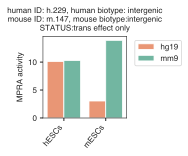

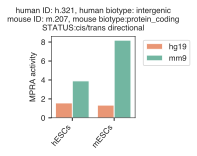

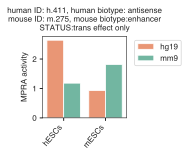

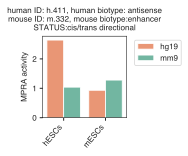

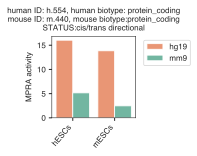

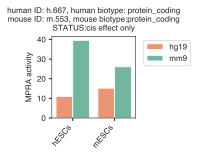

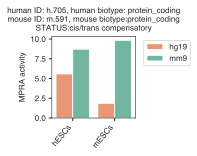

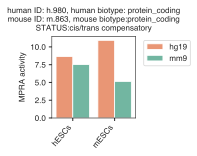

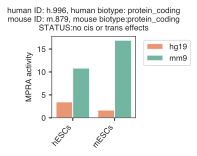

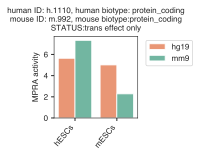

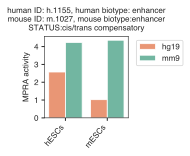

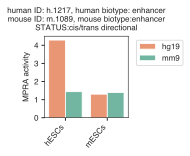

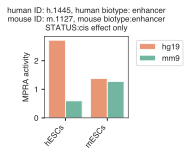

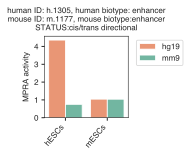

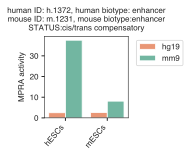

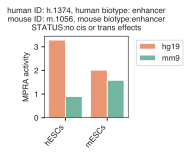

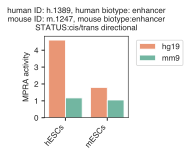

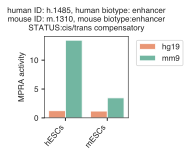

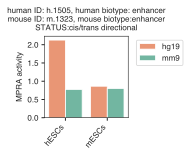

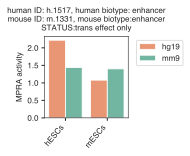

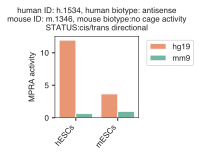

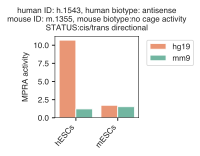

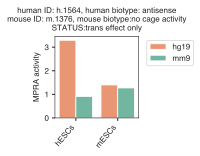

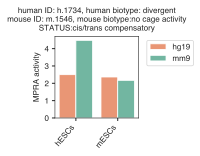

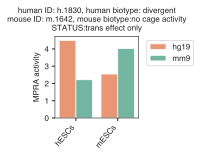

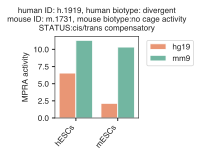

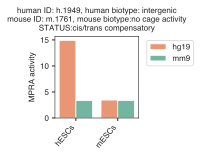

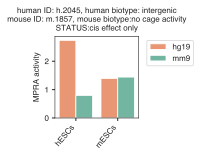

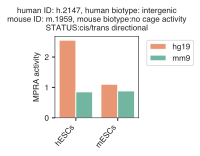

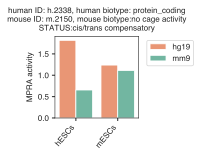

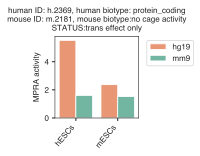

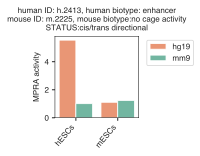

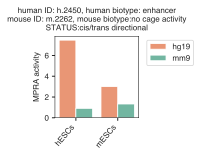

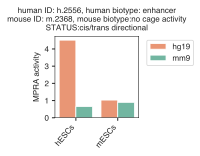

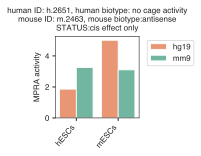

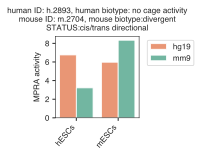

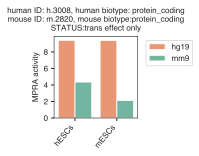

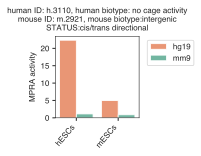

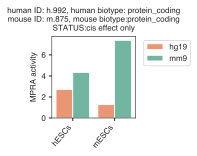

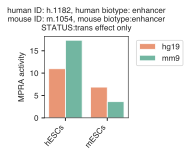

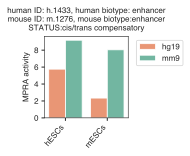

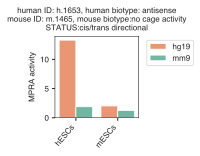

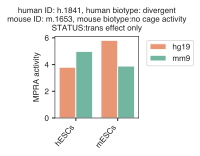

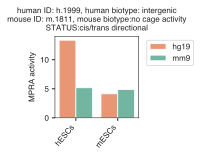

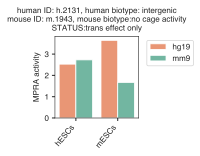

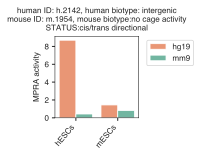

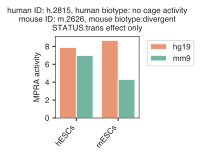

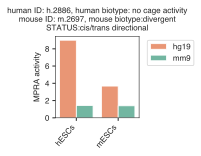

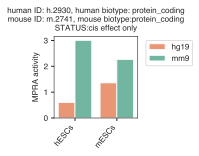

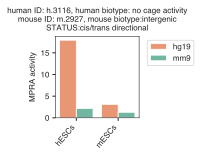

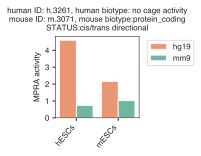

In [44]:
for row in sub.iterrows():
    samp = pd.DataFrame(row[1]).T
    melt = pd.melt(samp, id_vars=["hg19_id", "mm9_id", "biotype_hg19", "biotype_mm9", "biotype_switch_minimal", 
                                  "logFC_int", "logFC_cis_HUES64", "logFC_cis_mESC", "cis_trans_status"])
    melt["cell"] = melt["variable"].str.split("_", expand=True)[0]
    melt["seq"] = melt["variable"].str.split("_", expand=True)[1]
    
    fig = plt.figure(figsize=(1.5, 1.5))
    ax = sns.barplot(data=melt, x="cell", hue="seq", y="value", palette=pal)
    ax.set_ylabel("MPRA activity")
    ax.set_xlabel("")
    ax.set_xticklabels(["hESCs", "mESCs"], rotation=50, ha='right', va='top')
    ax.set_title("human ID: %s, human biotype: %s\nmouse ID: %s, mouse biotype:%s\nSTATUS:%s" % (row[1].hg19_id, 
                                                                                      row[1].biotype_hg19, 
                                                                                      row[1].mm9_id,
                                                                                      row[1].biotype_mm9,
                                                                                                 row[1].cis_trans_status))
    plt.legend(loc=2, bbox_to_anchor=(1.05, 1))
    plt.show()
    plt.close()
#     fig.savefig("%s.%s.barplot.pdf" % (row[1].hg19_id, row[1].mm9_id), dpi="figure", bbox_inches="tight")

examples:
- compensatory: h.1433/m.1276, 
- directional: h.321/m.207, h.554/m.440, h.1389/m.1247

In [45]:
# for row in sub.head(3).iterrows():
#     arr = np.zeros((2, 2))
#     arr[0, 0] = row[1].HUES64_hg19
#     arr[0, 1] = row[1].HUES64_mm9
#     arr[1, 0] = row[1].mESC_hg19
#     arr[1, 1] = row[1].mESC_mm9
    
#     fig, ax = plt.subplots(figsize=(2, 2), nrows=1, ncols=1)
#     sns.heatmap(arr, annot=True, cmap="Greys", cbar=False, ax=ax, linewidths=30, vmin=0, vmax=20)
    
#     ax.plot([0, 0], [1, 1], color="black")
#     plt.show()

## 9. look at cis/trans when subsetting by native

In [46]:
# for df, title, label in zip(dfs, titles, labels):
    
#     fig, axarr = plt.subplots(figsize=(5.8, 2), nrows=1, ncols=3, sharex=True, sharey=True)
    
#     # all seqs
#     ax = axarr[0]
#     ax.scatter(df["logFC_cis_one"], df["logFC_trans_one"], s=10, alpha=0.75, 
#                color="gray", linewidths=0.5, edgecolors="white")

#     plt.xlabel("cis effect size")
#     plt.ylabel("trans effect size")

#     ax.axhline(y=0, color="black", linestyle="dashed")
#     ax.axvline(x=0, color="black", linestyle="dashed")

#     # annotate corr
#     no_nan = df[(~pd.isnull(df["logFC_cis_one"])) & (~pd.isnull(df["logFC_trans_one"]))]
#     r, p = spearmanr(no_nan["logFC_cis_one"], no_nan["logFC_trans_one"])
#     ax.text(0.05, 0.97, "r = {:.2f}".format(r), ha="left", va="top", fontsize=fontsize,
#             transform=ax.transAxes)
#     ax.text(0.05, 0.90, "n = %s" % (len(no_nan)), ha="left", va="top", fontsize=fontsize,
#             transform=ax.transAxes)
    
#     # native effects only
#     sub = df[df["native_status"] == "significant native effect"]
#     ax = axarr[1]
#     ax.scatter(sub["logFC_cis_one"], sub["logFC_trans_one"], s=10, alpha=0.75, 
#                color="gray", linewidths=0.5, edgecolors="white")

#     plt.xlabel("cis effect size")
#     plt.ylabel("trans effect size")

#     ax.axhline(y=0, color="black", linestyle="dashed")
#     ax.axvline(x=0, color="black", linestyle="dashed")

#     # annotate corr
#     no_nan = sub[(~pd.isnull(sub["logFC_cis_one"])) & (~pd.isnull(sub["logFC_trans_one"]))]
#     r, p = spearmanr(no_nan["logFC_cis_one"], no_nan["logFC_trans_one"])
#     ax.text(0.05, 0.97, "r = {:.2f}".format(r), ha="left", va="top", fontsize=fontsize,
#             transform=ax.transAxes)
#     ax.text(0.05, 0.90, "n = %s" % (len(no_nan)), ha="left", va="top", fontsize=fontsize,
#             transform=ax.transAxes)
    
#     # no native effects
#     sub = df[df["native_status"] == "no native effect"]
#     ax = axarr[2]
#     ax.scatter(sub["logFC_cis_one"], sub["logFC_trans_one"], s=10, alpha=0.75, 
#                color="gray", linewidths=0.5, edgecolors="white")

#     plt.xlabel("cis effect size")
#     plt.ylabel("trans effect size")

#     ax.axhline(y=0, color="black", linestyle="dashed")
#     ax.axvline(x=0, color="black", linestyle="dashed")

#     # annotate corr
#     no_nan = sub[(~pd.isnull(sub["logFC_cis_one"])) & (~pd.isnull(sub["logFC_trans_one"]))]
#     r, p = spearmanr(no_nan["logFC_cis_one"], no_nan["logFC_trans_one"])
#     ax.text(0.05, 0.97, "r = {:.2f}".format(r), ha="left", va="top", fontsize=fontsize,
#             transform=ax.transAxes)
#     ax.text(0.05, 0.90, "n = %s" % (len(no_nan)), ha="left", va="top", fontsize=fontsize,
#             transform=ax.transAxes)
    
#     ax.set_xlabel("")
#     ax.set_ylabel("")
    
# #     fig.savefig("cis_v_trans.%s.pdf" % label, dpi="figure", bbox_inches="tight")

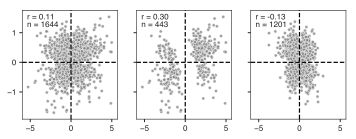

In [47]:
fig, axarr = plt.subplots(figsize=(5.8, 2), nrows=1, ncols=3, sharex=True, sharey=True)

# all seqs
ax = axarr[0]
ax.scatter(df["logFC_cis_one"], df["logFC_trans_one"], s=10, alpha=0.75, 
           color="gray", linewidths=0.5, edgecolors="white")

plt.xlabel("cis effect size")
plt.ylabel("trans effect size")

ax.axhline(y=0, color="black", linestyle="dashed")
ax.axvline(x=0, color="black", linestyle="dashed")

# annotate corr
no_nan = df[(~pd.isnull(df["logFC_cis_one"])) & (~pd.isnull(df["logFC_trans_one"]))]
r, p = spearmanr(no_nan["logFC_cis_one"], no_nan["logFC_trans_one"])
ax.text(0.05, 0.97, "r = {:.2f}".format(r), ha="left", va="top", fontsize=fontsize,
        transform=ax.transAxes)
ax.text(0.05, 0.90, "n = %s" % (len(no_nan)), ha="left", va="top", fontsize=fontsize,
        transform=ax.transAxes)

# native effects only
sub = df[df["native_status"] == "significant native effect"]
ax = axarr[1]
ax.scatter(sub["logFC_cis_one"], sub["logFC_trans_one"], s=10, alpha=0.75, 
           color="gray", linewidths=0.5, edgecolors="white")

plt.xlabel("cis effect size")
plt.ylabel("trans effect size")

ax.axhline(y=0, color="black", linestyle="dashed")
ax.axvline(x=0, color="black", linestyle="dashed")

# annotate corr
no_nan = sub[(~pd.isnull(sub["logFC_cis_one"])) & (~pd.isnull(sub["logFC_trans_one"]))]
r, p = spearmanr(no_nan["logFC_cis_one"], no_nan["logFC_trans_one"])
ax.text(0.05, 0.97, "r = {:.2f}".format(r), ha="left", va="top", fontsize=fontsize,
        transform=ax.transAxes)
ax.text(0.05, 0.90, "n = %s" % (len(no_nan)), ha="left", va="top", fontsize=fontsize,
        transform=ax.transAxes)

# no native effects
sub = df[df["native_status"] == "no native effect"]
ax = axarr[2]
ax.scatter(sub["logFC_cis_one"], sub["logFC_trans_one"], s=10, alpha=0.75, 
           color="gray", linewidths=0.5, edgecolors="white")

plt.xlabel("cis effect size")
plt.ylabel("trans effect size")

ax.axhline(y=0, color="black", linestyle="dashed")
ax.axvline(x=0, color="black", linestyle="dashed")

# annotate corr
no_nan = sub[(~pd.isnull(sub["logFC_cis_one"])) & (~pd.isnull(sub["logFC_trans_one"]))]
r, p = spearmanr(no_nan["logFC_cis_one"], no_nan["logFC_trans_one"])
ax.text(0.05, 0.97, "r = {:.2f}".format(r), ha="left", va="top", fontsize=fontsize,
        transform=ax.transAxes)
ax.text(0.05, 0.90, "n = %s" % (len(no_nan)), ha="left", va="top", fontsize=fontsize,
        transform=ax.transAxes)

ax.set_xlabel("")
ax.set_ylabel("")

#     fig.savefig("cis_v_trans.%s.pdf" % label, dpi="figure", bbox_inches="tight")

## 10. look at invidiual directionality of cis/trans

In [48]:
# for df, title, label in zip(dfs, titles, labels):
#     res = {}
#     cis_trans = df[(df["cis_status_one"] == "significant cis effect") & 
#                    (df["trans_status_one"] == "significant trans effect")]
#     tots = len(cis_trans)
#     print(tots)
#     res["total"] = [tots]
#     direc = cis_trans[((cis_trans["cis_status_det_one"].str.contains("higher in human") & 
#                         cis_trans["trans_status_det_one"].str.contains("higher in human")) |
#                        (cis_trans["cis_status_det_one"].str.contains("higher in mouse") &
#                         cis_trans["trans_status_det_one"].str.contains("higher in mouse")))]    
#     direc = len(direc)
#     res["directional"] = [direc]

#     comp = cis_trans[((cis_trans["cis_status_det_one"].str.contains("higher in human") & 
#                         cis_trans["trans_status_det_one"].str.contains("higher in mouse")) |
#                        (cis_trans["cis_status_det_one"].str.contains("higher in mouse") &
#                         cis_trans["trans_status_det_one"].str.contains("higher in human")))]
#     comp = len(comp)
#     res["compensatory"] = [comp]
#     res = pd.DataFrame.from_dict(res, orient="index").reset_index()
#     res["perc"] = (res[0]/tots)*100
#     res["tmp"] = "tmp"
    
#     fig, ax = plt.subplots(figsize=(0.5, 1.5), nrows=1, ncols=1)
#     sns.barplot(data=res[res["index"] == "total"], 
#                 x="tmp", y="perc", color=sns.color_palette("Set2")[7], ax=ax)
#     sns.barplot(data=res[res["index"] == "directional"], 
#                 x="tmp", y="perc", color=sns.color_palette("Set2")[2], ax=ax)
    
#     ax.set_xlabel("")
#     ax.set_ylabel("% of sequence pairs")
#     ax.set_xticklabels(["all pairs"], rotation=50, ha="right", va="top")
    
#     ax.annotate(str(tots), xy=(0, 5), xycoords="data", xytext=(0, 0), 
#                 textcoords="offset pixels", ha='center', va='bottom', 
#                 color="white", size=fontsize)
    
#     fig.savefig("direc_v_comp.%s.pdf" % label, dpi="figure", bbox_inches="tight")

159
          index    0        perc  tmp
0         total  159  100.000000  tmp
1   directional   95   59.748428  tmp
2  compensatory   64   40.251572  tmp


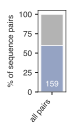

In [49]:
res = {}
cis_trans = df[(df["cis_status_one"] == "significant cis effect") & 
               (df["trans_status_one"] == "significant trans effect")]
tots = len(cis_trans)
print(tots)
res["total"] = [tots]
direc = cis_trans[((cis_trans["cis_status_det_one"].str.contains("higher in human") & 
                    cis_trans["trans_status_det_one"].str.contains("higher in human")) |
                   (cis_trans["cis_status_det_one"].str.contains("higher in mouse") &
                    cis_trans["trans_status_det_one"].str.contains("higher in mouse")))]    
direc = len(direc)
res["directional"] = [direc]

comp = cis_trans[((cis_trans["cis_status_det_one"].str.contains("higher in human") & 
                    cis_trans["trans_status_det_one"].str.contains("higher in mouse")) |
                   (cis_trans["cis_status_det_one"].str.contains("higher in mouse") &
                    cis_trans["trans_status_det_one"].str.contains("higher in human")))]
comp = len(comp)
res["compensatory"] = [comp]
res = pd.DataFrame.from_dict(res, orient="index").reset_index()
res["perc"] = (res[0]/tots)*100
res["tmp"] = "tmp"
print(res)

fig, ax = plt.subplots(figsize=(0.5, 1.5), nrows=1, ncols=1)
sns.barplot(data=res[res["index"] == "total"], 
            x="tmp", y="perc", color=sns.color_palette("Set2")[7], ax=ax)
sns.barplot(data=res[res["index"] == "directional"], 
            x="tmp", y="perc", color=sns.color_palette("Set2")[2], ax=ax)

ax.set_xlabel("")
ax.set_ylabel("% of sequence pairs")
ax.set_xticklabels(["all pairs"], rotation=50, ha="right", va="top")

ax.annotate(str(tots), xy=(0, 5), xycoords="data", xytext=(0, 0), 
            textcoords="offset pixels", ha='center', va='bottom', 
            color="white", size=fontsize)

fig.savefig("direc_v_comp.pdf", dpi="figure", bbox_inches="tight")

In [50]:
# for df, title, label in zip(dfs, titles, labels):

#     cis_trans = df[(df["cis_status_one"] == "significant cis effect") & 
#                    (df["trans_status_one"] == "significant trans effect")]
#     tots = cis_trans.groupby("biotype_switch_minimal")["hg19_id"].agg("count").reset_index()
    
#     direc = cis_trans[((cis_trans["cis_status_det_one"].str.contains("higher in human") & 
#                         cis_trans["trans_status_det_one"].str.contains("higher in human")) |
#                        (cis_trans["cis_status_det_one"].str.contains("higher in mouse") &
#                         cis_trans["trans_status_det_one"].str.contains("higher in mouse")))]
#     sig = direc.groupby("biotype_switch_minimal")["hg19_id"].agg("count").reset_index()
#     clean_sig = tots.merge(sig, on="biotype_switch_minimal", how="left").fillna(0)
#     clean_sig["percent_sig"] = (clean_sig["hg19_id_y"]/clean_sig["hg19_id_x"])*100
#     clean_sig["percent_tot"] = (clean_sig["hg19_id_x"]/clean_sig["hg19_id_x"])*100
    
#     fig = plt.figure(figsize=(2.5, 1.5))
#     ax = sns.barplot(data=clean_sig, x="biotype_switch_minimal", y="percent_tot", 
#                      order=min_switch_order, color=sns.color_palette("Set2")[7])
#     sns.barplot(data=clean_sig, x="biotype_switch_minimal", y="percent_sig", 
#                 order=min_switch_order, color=sns.color_palette("Set2")[2])

#     ax.set_xticklabels(["eRNA", "lncRNA", "mRNA", "eRNA", "lncRNA", "mRNA"], rotation=50, ha='right', va='top')
#     ax.set_xlabel("")
#     ax.set_ylabel("% of sequence pairs")
#     ax.set_title(title)
#     ax.axvline(x=2.5, linestyle="dashed", color="black")
    
#     for i, l in enumerate(min_switch_order):
#         sub = clean_sig[clean_sig["biotype_switch_minimal"] == l]
#         print("%s perc sig: %s" % (l, sub["percent_sig"].iloc[0]))
#         n = sub["hg19_id_x"].iloc[0]
#         ax.annotate(str(n), xy=(i, 5), xycoords="data", xytext=(0, 0), 
#                     textcoords="offset pixels", ha='center', va='bottom', 
#                     color="white", size=fontsize)
    
#     plt.show()
#     fig.savefig("perc_sig_compensatory_minimal_biotype_switch.%s.pdf" % label, dpi="figure", bbox_inches="tight")
#     plt.close()

CAGE turnover - eRNA perc sig: 100.0
CAGE turnover - lncRNA perc sig: 64.7058823529
CAGE turnover - mRNA perc sig: 60.0
eRNA perc sig: 75.0
lncRNA perc sig: 42.8571428571
mRNA perc sig: 42.1052631579


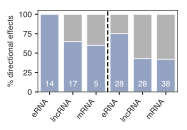

In [51]:
cis_trans = df[(df["cis_status_one"] == "significant cis effect") & 
               (df["trans_status_one"] == "significant trans effect")]
tots = cis_trans.groupby("biotype_switch_minimal")["hg19_id"].agg("count").reset_index()

direc = cis_trans[((cis_trans["cis_status_det_one"].str.contains("higher in human") & 
                    cis_trans["trans_status_det_one"].str.contains("higher in human")) |
                   (cis_trans["cis_status_det_one"].str.contains("higher in mouse") &
                    cis_trans["trans_status_det_one"].str.contains("higher in mouse")))]
sig = direc.groupby("biotype_switch_minimal")["hg19_id"].agg("count").reset_index()
clean_sig = tots.merge(sig, on="biotype_switch_minimal", how="left").fillna(0)
clean_sig["percent_sig"] = (clean_sig["hg19_id_y"]/clean_sig["hg19_id_x"])*100
clean_sig["percent_tot"] = (clean_sig["hg19_id_x"]/clean_sig["hg19_id_x"])*100

fig = plt.figure(figsize=(2.5, 1.5))
ax = sns.barplot(data=clean_sig, x="biotype_switch_minimal", y="percent_tot", 
                 order=min_switch_order, color=sns.color_palette("Set2")[7])
sns.barplot(data=clean_sig, x="biotype_switch_minimal", y="percent_sig", 
            order=min_switch_order, color=sns.color_palette("Set2")[2])

ax.set_xticklabels(["eRNA", "lncRNA", "mRNA", "eRNA", "lncRNA", "mRNA"], rotation=50, ha='right', va='top')
ax.set_xlabel("")
ax.set_ylabel("% directional effects")
ax.axvline(x=2.5, linestyle="dashed", color="black")

for i, l in enumerate(min_switch_order):
    sub = clean_sig[clean_sig["biotype_switch_minimal"] == l]
    print("%s perc sig: %s" % (l, sub["percent_sig"].iloc[0]))
    n = sub["hg19_id_x"].iloc[0]
    ax.annotate(str(n), xy=(i, 5), xycoords="data", xytext=(0, 0), 
                textcoords="offset pixels", ha='center', va='bottom', 
                color="white", size=fontsize)

plt.show()
fig.savefig("perc_sig_compensatory_minimal_biotype_switch.pdf", dpi="figure", bbox_inches="tight")
plt.close()

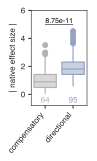

In [52]:
cis_trans_order = ["cis/trans compensatory", "cis/trans directional"]
cis_trans_pal = {"cis/trans compensatory": sns.color_palette("Set2")[7], 
                 "cis/trans directional": sns.color_palette("Set2")[2]}
df["abs_logFC_native"] = np.abs(df["logFC_native"])

fig = plt.figure(figsize=(1, 1.75))
ax = sns.boxplot(data=df, x="cis_trans_status", y="abs_logFC_native", 
                 flierprops = dict(marker='o', markersize=5), 
                 order=cis_trans_order, palette=cis_trans_pal)
mimic_r_boxplot(ax)

ax.set_xticklabels(["compensatory", "directional"], rotation=50, ha='right', va='top')
ax.set_xlabel("")
ax.set_ylabel(r'$\vert$ native effect size $\vert$')

for i, l in enumerate(cis_trans_order):
    sub = df[df["cis_trans_status"] == l]
    n = len(sub)
    color = cis_trans_pal[l]
    ax.annotate(str(n), xy=(i, -0.7), xycoords="data", xytext=(0, 0), 
                textcoords="offset pixels", ha='center', va='bottom', 
                color=color, size=fontsize)
    
sub1 = df[df["cis_trans_status"] == "cis/trans compensatory"]
sub2 = df[df["cis_trans_status"] == "cis/trans directional"]
    
vals1 = np.asarray(sub1["abs_logFC_native"])
vals2 = np.asarray(sub2["abs_logFC_native"])

vals1 = vals1[~np.isnan(vals1)]
vals2 = vals2[~np.isnan(vals2)]

u, pval = stats.mannwhitneyu(vals1, vals2, alternative="two-sided", use_continuity=False)
annotate_pval(ax, 0, 1, 5, 0, 5, pval, fontsize-1)
ax.set_ylim((-0.8, 6))
fig.savefig("native_effect_comp_v_dir.pdf", dpi="figure", bbox_inches="tight")

## 11. plot some examples

### compensatory

In [53]:
ex = df[df["hg19_id"] == "h.1433"]
ex = ex[["hg19_id", "mm9_id", "minimal_biotype_hg19", "minimal_biotype_mm9", "HUES64_hg19", "HUES64_mm9",
         "mESC_hg19", "mESC_mm9", "trans_human_status_det", "fdr_trans_human", "trans_mouse_status_det", 
         "fdr_trans_mouse", "cis_HUES64_status_det", "fdr_cis_HUES64", "cis_mESC_status_det", "fdr_cis_mESC",
         "logFC_trans_human", "logFC_trans_mouse", "logFC_cis_HUES64", "logFC_cis_mESC"]]
ex

hg19_id  mm9_id minimal_biotype_hg19 minimal_biotype_mm9  HUES64_hg19  \
2575  h.1433  m.1276                 eRNA                eRNA       5.7626   

      HUES64_mm9  mESC_hg19  mESC_mm9           trans_human_status_det  \
2575    9.174341   2.341169   8.04181  trans effect\n(higher in human)   

      fdr_trans_human trans_mouse_status_det  fdr_trans_mouse  \
2575     2.640306e-10        no trans effect           0.9048   

              cis_HUES64_status_det  fdr_cis_HUES64  \
2575  cis effect\n(higher in mouse)    2.725712e-07   

                cis_mESC_status_det  fdr_cis_mESC  logFC_trans_human  \
2575  cis effect\n(higher in mouse)  1.754477e-17          -0.725202   

      logFC_trans_mouse  logFC_cis_HUES64  logFC_cis_mESC  
2575           0.016883          0.773398        1.547024

In [54]:
ex = pd.melt(ex, id_vars=["hg19_id", "mm9_id", "minimal_biotype_hg19", "minimal_biotype_mm9"])
ex = ex[ex["variable"].isin(["HUES64_hg19", "HUES64_mm9", "mESC_hg19", "mESC_mm9",
                             "fdr_cis_HUES64", "fdr_cis_mESC",
                             "fdr_trans_human", "fdr_trans_mouse", "logFC_cis_HUES64", "logFC_cis_mESC",
                             "logFC_trans_human", "logFC_trans_mouse"])]

In [55]:
ex["cell"] = ex["variable"].str.split("_", expand=True)[0]
ex["seq"] = ex["variable"].str.split("_", expand=True)[1]
ex.head()

hg19_id  mm9_id minimal_biotype_hg19 minimal_biotype_mm9         variable  \
0  h.1433  m.1276                 eRNA                eRNA      HUES64_hg19   
1  h.1433  m.1276                 eRNA                eRNA       HUES64_mm9   
2  h.1433  m.1276                 eRNA                eRNA        mESC_hg19   
3  h.1433  m.1276                 eRNA                eRNA         mESC_mm9   
5  h.1433  m.1276                 eRNA                eRNA  fdr_trans_human   

         value    cell    seq  
0       5.7626  HUES64   hg19  
1      9.17434  HUES64    mm9  
2      2.34117    mESC   hg19  
3      8.04181    mESC    mm9  
5  2.64031e-10     fdr  trans

In [56]:
order = ["HUES64", "mESC"]
hue_order = ["hg19", "mm9"]
pal = {"hg19": sns.color_palette("Set2")[1], "mm9": sns.color_palette("Set2")[0]}

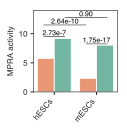

In [57]:
fig = plt.figure(figsize=(1.5, 1.5))

sub = ex[ex["cell"].isin(["HUES64", "mESC"])]
ax = sns.barplot(data=sub, x="cell", y="value", hue="seq", order=order, hue_order=hue_order, palette=pal)
ax.set_xticklabels(["hESCs", "mESCs"], rotation=50, va="top", ha="right")
ax.set_ylabel("MPRA activity")
ax.set_xlabel("")
ax.get_legend().remove()

ax.set_ylim((0, 14))
annotate_pval(ax, -0.25, 0.25, 9.5, 0, 9.5, ex[ex["variable"] == "fdr_cis_HUES64"]["value"].iloc[0], fontsize-1)
annotate_pval(ax, 0.75, 1.25, 8.25, 0, 8.25, ex[ex["variable"] == "fdr_cis_mESC"]["value"].iloc[0], fontsize-1)
annotate_pval(ax, -0.25, 0.75, 11.5, 0, 11.5, ex[ex["variable"] == "fdr_trans_human"]["value"].iloc[0], fontsize-1)
annotate_pval(ax, 0.25, 1.25, 12.75, 0, 12.75, ex[ex["variable"] == "fdr_trans_mouse"]["value"].iloc[0], fontsize-1)

fig.savefig("compensatory_example_barplot.pdf", dpi="figure", bbox_inches="tight")

In [58]:
ex_sub = ex[ex["variable"].str.contains("logFC")]
ex_sub["sp"] = ex_sub["variable"].str.split("_", expand=True)[2]
ex_sub = ex_sub.sort_values(by=["seq", "sp"])
ex_sub

hg19_id  mm9_id minimal_biotype_hg19 minimal_biotype_mm9  \
14  h.1433  m.1276                 eRNA                eRNA   
15  h.1433  m.1276                 eRNA                eRNA   
12  h.1433  m.1276                 eRNA                eRNA   
13  h.1433  m.1276                 eRNA                eRNA   

             variable      value   cell    seq      sp  
14   logFC_cis_HUES64   0.773398  logFC    cis  HUES64  
15     logFC_cis_mESC    1.54702  logFC    cis    mESC  
12  logFC_trans_human  -0.725202  logFC  trans   human  
13  logFC_trans_mouse  0.0168829  logFC  trans   mouse

In [59]:
def sp(row):
    if row.sp in ["HUES64", "human"]:
        return "human"
    else:
        return "mouse"
    
ex_sub["sp"] = ex_sub.apply(sp, axis=1)
ex_sub

hg19_id  mm9_id minimal_biotype_hg19 minimal_biotype_mm9  \
14  h.1433  m.1276                 eRNA                eRNA   
15  h.1433  m.1276                 eRNA                eRNA   
12  h.1433  m.1276                 eRNA                eRNA   
13  h.1433  m.1276                 eRNA                eRNA   

             variable      value   cell    seq     sp  
14   logFC_cis_HUES64   0.773398  logFC    cis  human  
15     logFC_cis_mESC    1.54702  logFC    cis  mouse  
12  logFC_trans_human  -0.725202  logFC  trans  human  
13  logFC_trans_mouse  0.0168829  logFC  trans  mouse

In [60]:
order = ["cis", "trans"]

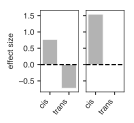

In [61]:
fig, axarr = plt.subplots(figsize=(1.5, 1.5), nrows=1, ncols=2, sharey=True)
human_ax = axarr[0]
mouse_ax = axarr[1]

sub = ex_sub[ex_sub["sp"] == "human"]
sns.barplot(data=sub, x="seq", y="value", ax=human_ax, color=sns.color_palette("Set2")[7])
human_ax.set_xticklabels(order, rotation=50, va="top", ha="right")
human_ax.set_ylabel("effect size")
human_ax.set_xlabel("")
human_ax.axhline(y=0, linestyle="dashed", color="black")

sub = ex_sub[ex_sub["sp"] == "mouse"]
sns.barplot(data=sub, x="seq", y="value", ax=mouse_ax, color=sns.color_palette("Set2")[7])
mouse_ax.set_xticklabels(order, rotation=50, va="top", ha="right")
mouse_ax.set_ylabel("")
mouse_ax.set_xlabel("")
mouse_ax.axhline(y=0, linestyle="dashed", color="black")
fig.savefig("compensatory_example_effectsize.pdf", dpi="figure", bbox_inches="tight")

### directional

In [62]:
ex = df[df["hg19_id"] == "h.1389"]
ex = ex[["hg19_id", "mm9_id", "minimal_biotype_hg19", "minimal_biotype_mm9", "HUES64_hg19", "HUES64_mm9",
         "mESC_hg19", "mESC_mm9", "trans_human_status_det", "fdr_trans_human", "trans_mouse_status_det", 
         "fdr_trans_mouse", "cis_HUES64_status_det", "fdr_cis_HUES64", "cis_mESC_status_det", "fdr_cis_mESC",
         "logFC_trans_human", "logFC_trans_mouse", "logFC_cis_HUES64", "logFC_cis_mESC"]]
ex

hg19_id  mm9_id minimal_biotype_hg19 minimal_biotype_mm9  HUES64_hg19  \
905  h.1389  m.1247                 eRNA                eRNA     4.604656   

     HUES64_mm9  mESC_hg19  mESC_mm9           trans_human_status_det  \
905    1.173973   1.796721  1.049326  trans effect\n(higher in human)   

     fdr_trans_human trans_mouse_status_det  fdr_trans_mouse  \
905     6.465697e-07        no trans effect         0.773881   

             cis_HUES64_status_det  fdr_cis_HUES64 cis_mESC_status_det  \
905  cis effect\n(higher in human)    2.416348e-10       no cis effect   

     fdr_cis_mESC  logFC_trans_human  logFC_trans_mouse  logFC_cis_HUES64  \
905      0.274005          -0.768599             0.0626         -1.144567   

     logFC_cis_mESC  
905       -0.268827

In [63]:
ex = pd.melt(ex, id_vars=["hg19_id", "mm9_id", "minimal_biotype_hg19", "minimal_biotype_mm9"])
ex = ex[ex["variable"].isin(["HUES64_hg19", "HUES64_mm9", "mESC_hg19", "mESC_mm9",
                             "fdr_cis_HUES64", "fdr_cis_mESC",
                             "fdr_trans_human", "fdr_trans_mouse", "logFC_cis_HUES64", "logFC_cis_mESC",
                             "logFC_trans_human", "logFC_trans_mouse"])]

In [64]:
ex["cell"] = ex["variable"].str.split("_", expand=True)[0]
ex["seq"] = ex["variable"].str.split("_", expand=True)[1]
ex.head()

hg19_id  mm9_id minimal_biotype_hg19 minimal_biotype_mm9         variable  \
0  h.1389  m.1247                 eRNA                eRNA      HUES64_hg19   
1  h.1389  m.1247                 eRNA                eRNA       HUES64_mm9   
2  h.1389  m.1247                 eRNA                eRNA        mESC_hg19   
3  h.1389  m.1247                 eRNA                eRNA         mESC_mm9   
5  h.1389  m.1247                 eRNA                eRNA  fdr_trans_human   

        value    cell    seq  
0     4.60466  HUES64   hg19  
1     1.17397  HUES64    mm9  
2     1.79672    mESC   hg19  
3     1.04933    mESC    mm9  
5  6.4657e-07     fdr  trans

In [65]:
order = ["HUES64", "mESC"]
hue_order = ["hg19", "mm9"]
pal = {"hg19": sns.color_palette("Set2")[1], "mm9": sns.color_palette("Set2")[0]}

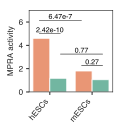

In [66]:
fig = plt.figure(figsize=(1.5, 1.5))

sub = ex[ex["cell"].isin(["HUES64", "mESC"])]
ax = sns.barplot(data=sub, x="cell", y="value", hue="seq", order=order, hue_order=hue_order, palette=pal)
ax.set_xticklabels(["hESCs", "mESCs"], rotation=50, va="top", ha="right")
ax.set_ylabel("MPRA activity")
ax.set_xlabel("")
ax.get_legend().remove()

ax.set_ylim((0, 7))
annotate_pval(ax, -0.25, 0.25, 5, 0, 5, ex[ex["variable"] == "fdr_cis_HUES64"]["value"].iloc[0], fontsize-1)
annotate_pval(ax, 0.75, 1.25, 2.25, 0, 2.25, ex[ex["variable"] == "fdr_cis_mESC"]["value"].iloc[0], fontsize-1)
annotate_pval(ax, -0.25, 0.75, 6.15, 0, 6.15, ex[ex["variable"] == "fdr_trans_human"]["value"].iloc[0], fontsize-1)
annotate_pval(ax, 0.25, 1.25, 3.25, 0, 3.25, ex[ex["variable"] == "fdr_trans_mouse"]["value"].iloc[0], fontsize-1)

fig.savefig("directional_example_barplot.pdf", dpi="figure", bbox_inches="tight")

In [67]:
ex_sub = ex[ex["variable"].str.contains("logFC")]
ex_sub["sp"] = ex_sub["variable"].str.split("_", expand=True)[2]
ex_sub = ex_sub.sort_values(by=["seq", "sp"])
ex_sub["sp"] = ex_sub.apply(sp, axis=1)
ex_sub

hg19_id  mm9_id minimal_biotype_hg19 minimal_biotype_mm9  \
14  h.1389  m.1247                 eRNA                eRNA   
15  h.1389  m.1247                 eRNA                eRNA   
12  h.1389  m.1247                 eRNA                eRNA   
13  h.1389  m.1247                 eRNA                eRNA   

             variable      value   cell    seq     sp  
14   logFC_cis_HUES64   -1.14457  logFC    cis  human  
15     logFC_cis_mESC  -0.268827  logFC    cis  mouse  
12  logFC_trans_human  -0.768599  logFC  trans  human  
13  logFC_trans_mouse  0.0625996  logFC  trans  mouse

In [68]:
order = ["cis", "trans"]

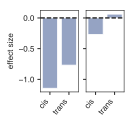

In [69]:
fig, axarr = plt.subplots(figsize=(1.5, 1.5), nrows=1, ncols=2, sharey=True)
human_ax = axarr[0]
mouse_ax = axarr[1]

sub = ex_sub[ex_sub["sp"] == "human"]
sns.barplot(data=sub, x="seq", y="value", ax=human_ax, color=sns.color_palette("Set2")[2])
human_ax.set_xticklabels(order, rotation=50, va="top", ha="right")
human_ax.set_ylabel("effect size")
human_ax.set_xlabel("")
human_ax.axhline(y=0, linestyle="dashed", color="black")

sub = ex_sub[ex_sub["sp"] == "mouse"]
sns.barplot(data=sub, x="seq", y="value", ax=mouse_ax, color=sns.color_palette("Set2")[2])
mouse_ax.set_xticklabels(order, rotation=50, va="top", ha="right")
mouse_ax.set_ylabel("")
mouse_ax.set_xlabel("")
mouse_ax.axhline(y=0, linestyle="dashed", color="black")
fig.savefig("directional_example_effectsize.pdf", dpi="figure", bbox_inches="tight")